In [1]:
# Mount Google dirve
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Define Project Folder
FOLDERNAME = 'Colab\ Notebooks'

%cd drive/MyDrive/$FOLDERNAME

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [2]:
# Define device
import torch
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')
print('Device:', device)

Device: cpu


In [3]:
## JSMA preparation

import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import torch.optim as optim
import torch.utils.data as data_utils
import math
import torchvision.models as models
from PIL import Image


# calculate jacobian matrix for forward deviation
def compute_jacobian(model, input):
    var_input = input.clone()

    var_input.detach_()
    var_input.requires_grad = True
    output = model(var_input)

    num_features = int(np.prod(var_input.shape[1:]))
    jacobian = torch.zeros([output.size()[1], num_features])
    for i in range(output.size()[1]):
        # zero_gradients(input)
        if var_input.grad is not None:
          var_input.grad.zero_()
        # output.backward(mask,retain_graph=True)
        output[0][i].backward(retain_graph=True)
        # copy the derivative to the target place
        jacobian[i] = var_input.grad.squeeze().view(-1, num_features).clone()

    return jacobian.to(device)

In [4]:
# Saliency map calcuation
# import torch, gc

def saliency_map(jacobian, target_index, increasing, search_space, nb_features):
    domain = torch.eq(search_space, 1).float()  # The search domain
    # the sum of all features' derivative with respect to each class
    all_sum = torch.sum(jacobian, dim=0, keepdim=True)
    target_grad = jacobian[target_index]  # The forward derivative of the target class
    others_grad = all_sum - target_grad  # The sum of forward derivative of other classes

    # this list blanks out those that are not in the search domain
    if increasing:
        increase_coef = 2 * (torch.eq(domain, 0)).float().to(device)
    else:
        increase_coef = -1 * 2 * (torch.eq(domain, 0)).float().to(device)
    increase_coef = increase_coef.view(-1, nb_features)

    # calculate sum of target forward derivative of any 2 features.
    target_tmp = target_grad.clone()
    target_tmp -= increase_coef * torch.max(torch.abs(target_grad))
    # gc.collect()
    # torch.cuda.empty_cache()
    alpha = target_tmp.view(-1, 1, nb_features) + target_tmp.view(-1, nb_features, 1)  # PyTorch will automatically extend the dimensions

    # calculate sum of other forward derivative of any 2 features.
    others_tmp = others_grad.clone()
    others_tmp += increase_coef * torch.max(torch.abs(others_grad))
    beta = others_tmp.view(-1, 1, nb_features) + others_tmp.view(-1, nb_features, 1)

    # zero out the situation where a feature sums with itself
    tmp = np.ones((nb_features, nb_features), int)
    np.fill_diagonal(tmp, 0)
    zero_diagonal = torch.from_numpy(tmp).byte().to(device)

    # According to the definition of saliency map in the paper (formulas 8 and 9),
    # those elements in the saliency map that doesn't satisfy the requirement will be blanked out.
    if increasing:
        mask1 = torch.gt(alpha, 0.0)
        mask2 = torch.lt(beta, 0.0)
    else:
        mask1 = torch.lt(alpha, 0.0)
        mask2 = torch.gt(beta, 0.0)
    # apply the mask to the saliency map
    mask = torch.mul(torch.mul(mask1, mask2), zero_diagonal.view_as(mask1))
    # do the multiplication according to formula 10 in the paper
    saliency_map = torch.mul(torch.mul(alpha, torch.abs(beta)), mask.float())
    # get the most significant two pixels
    max_value, max_idx = torch.max(saliency_map.view(-1, nb_features * nb_features), dim=1)
    p = max_idx // nb_features
    q = max_idx % nb_features
    return p, q, saliency_map

In [5]:
def perturbation_single(image, ys_target, theta, gamma, model):

    image.to(device)
    image_clone = image.clone()
    np_img = image_clone.resize_(1, 3*256*256).cpu().numpy()
    copy_sample = np.copy(np_img)
    var_sample =Variable(torch.from_numpy(copy_sample), requires_grad=True).to(device)

    # outputs = model(var_sample)
    # predicted = torch.max(outputs.data, 1)[1]
    # print('测试样本扰动前的预测值：{}'.format(predicted[0]))

    var_target = Variable(torch.LongTensor([ys_target,])).to(device)

    if theta > 0:
        increasing = True
    else:
        increasing = False

    num_features = int(np.prod(copy_sample.shape[1:]))
    # print(num_features)
    shape = image.size()
    # print(shape)

    # perturb two pixels in one iteration, thus max_iters is divided by 2.0
    max_iters = int(np.ceil(num_features * gamma / 2.0))

    # masked search domain, if the pixel has already reached the top or bottom, we don't bother to modify it.
    if increasing:
        search_domain = torch.lt(var_sample, 0.99) #逐一元素比較var_sample和0.99
    else:
        search_domain = torch.gt(var_sample, 0.01)
    search_domain = search_domain.view(num_features)

    model.eval().to(device)
    output = model(image)
    current = torch.max(output.data, 1)[1].cpu().numpy()
    # saliency = torch.zeros((1, 784, 784)).to(device)

    iter = 0
    while (iter < max_iters) and (current[0] != ys_target) and (search_domain.sum() != 0):
        # calculate Jacobian matrix of forward derivative
        jacobian = compute_jacobian(model, image)
        # get the saliency map and calculate the two pixels that have the greatest influence
        p1, p2= saliency_map(jacobian, var_target, increasing, search_domain, num_features)
        # apply modifications
        var_sample_flatten = var_sample.view(-1, num_features).clone().detach_()
        var_sample_flatten[0, p1] += theta
        var_sample_flatten[0, p2] += theta

        new_sample = torch.clamp(var_sample_flatten, min=0.0, max=1.0)
        new_sample = new_sample.view(shape)
        search_domain[p1] = 0
        search_domain[p2] = 0
        var_sample = Variable(torch.tensor(new_sample), requires_grad=True ).to(device)

        output = model(var_sample)
        current = torch.max(output.data, 1)[1].cpu().numpy()
        iter += 1

    adv_samples = var_sample.data.cpu().numpy()
    return adv_samples

In [6]:
## model

net = models.resnet34(pretrained=True)
net.to(device)
net.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

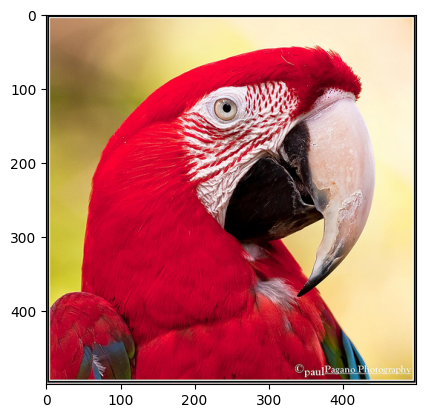

In [7]:
im_orig = Image.open('test_im1.jpg')
plt.imshow(im_orig)
mean = [ 0.485, 0.456, 0.406 ]
std = [ 0.229, 0.224, 0.225 ]

In [8]:
# get predict
from torch import Tensor
from easydict import EasyDict

labels = open(os.path.join('synset_words.txt'), 'r').read().split('\n')

def predict(model: nn.Module, img: Tensor):
  score = model(img)
  prediction = score.max(1)[1].item()
  label = labels[prediction]
  probability = F.softmax(score, dim=1)
  confidence = round(probability.max(1)[0].item(), 4)

  return EasyDict(
      id=prediction,
      label=label,
      confidence=confidence
  )

In [9]:
## Transform image to tensor
# Remove the mean
preprocess_fn = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

im = preprocess_fn(im_orig)
print(im.shape)
im = im.unsqueeze(0)
print(im.shape)

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])


In [10]:
prediction = predict(net, im.to(device))
print(prediction)

{'id': 88, 'label': 'n01818515 macaw', 'confidence': 1.0}


In [11]:
for i in range(len(labels)):
  if labels[i] == 'n02007558 flamingo':
    print(i)

130


In [ ]:
## gen JSMA
ys_target = 130
theta = 1.0
gamma = 0.1
print(im.shape)
pert = perturbation_single(im.to(device),ys_target,theta,gamma,net)
adv = torch.from_numpy(pert).resize_(1, 3, 256, 256).to(device)
print(adv.shape)

torch.Size([1, 3, 256, 256])


In [ ]:
# import torch
# torch.cuda.empty_cache()

In [ ]:
# adversarial attack prediction
prediction_adv = predict(net, adv)

In [ ]:
str_label_orig = prediction['label']
confidence_orig = prediction['confidence']
confidence_adv = prediction_adv['confidence']

In [ ]:
# transform tensor to image
def inverse_preprocess(x):
    t = x.squeeze(0)

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    t = t.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)) #.numpy()

    im = transforms.ToPILImage()(t) #.convert("RGB")

    return im

In [ ]:
# for visualization
import matplotlib.pyplot as plt

def plot(x, x_adv, x_grad, x_label, x_prob, x_adv_label, x_adv_prob):

    # figure, ax = plt.subplots(1,3, figsize=(18,8))
    figure, ax = plt.subplots(1,3, figsize=(12,8))
    ax[0].imshow(x)
    ax[0].set_title('Original', fontsize=16)

    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=16)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    ax[2].imshow(x_adv)
    ax[2].set_title('New', fontsize=16)

    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {:.0%}".format(x_label, x_prob), size=12, ha="center",
               transform=ax[0].transAxes)

    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {:.0%}".format(x_adv_label, x_adv_prob), size=12, ha="center",
               transform=ax[2].transAxes)


    plt.show()

In [ ]:
# perturbation
pert_diff = adv - im
adv_img = inverse_preprocess(adv)
pert_diff_img = transforms.ToPILImage()(pert_diff.squeeze(0))

In [ ]:
# visual
plot(im_orig, adv_img, pert_diff_img, str_label_orig, confidence_orig, ys_target, confidence_adv)